## 🛠️ Step 1: Install imbalanced-learn

We install the `imbalanced-learn` library, which is essential for handling imbalanced datasets.
It is a Python library that helps balance uneven datasets by resampling the classes, making models fairer and more accurate.

In [19]:
!pip install imbalanced-learn

## 📥 Step 2: Load the Dataset

We load the German Credit dataset using **pandas**, a powerful Python library used for handling tabular data.  
The dataset is stored as a CSV (Comma-Separated Values) file. The .head() function displays the first 5 rows of the dataset so we can quickly preview the data structure.



In [20]:
import pandas as pd

# Load dataset
df = pd.read_csv('/content/german_credit_data.csv')
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


## 📊 Step 3: Visualize Numeric & Categorical Features

### 🔹 Numeric Features

We plot all the numeric columns (like Age, Credit Amount, etc.) to see how their values are spread out.

We use **histograms** with smooth lines for a clearer view.

---

### 🔹 Categorical Features

We also plot the **categorical columns** (like Sex, Housing, Purpose, etc.) using bar charts.

This is useful before we move on to data preprocessing or model training.


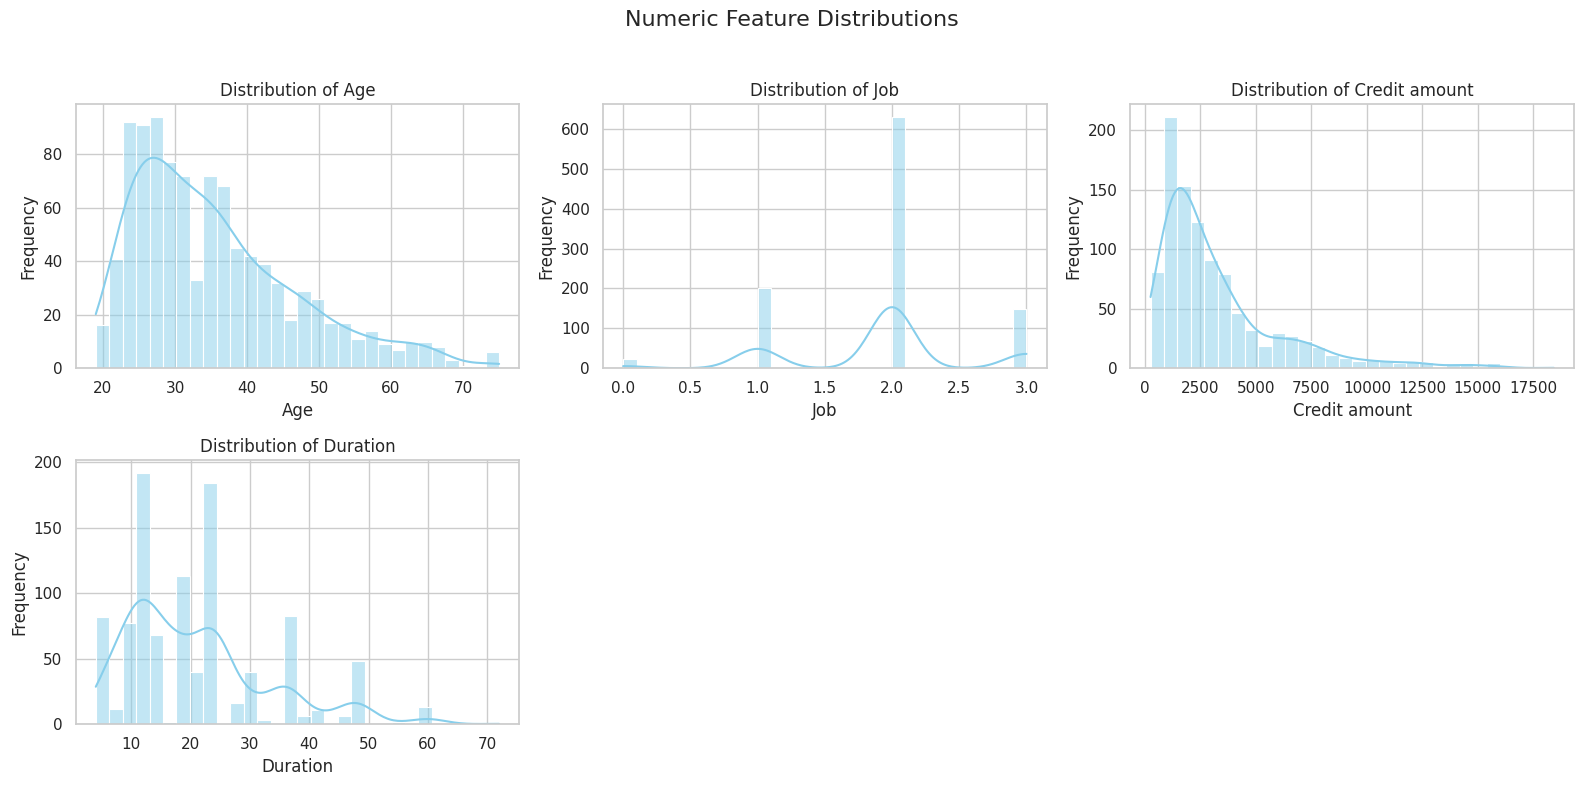

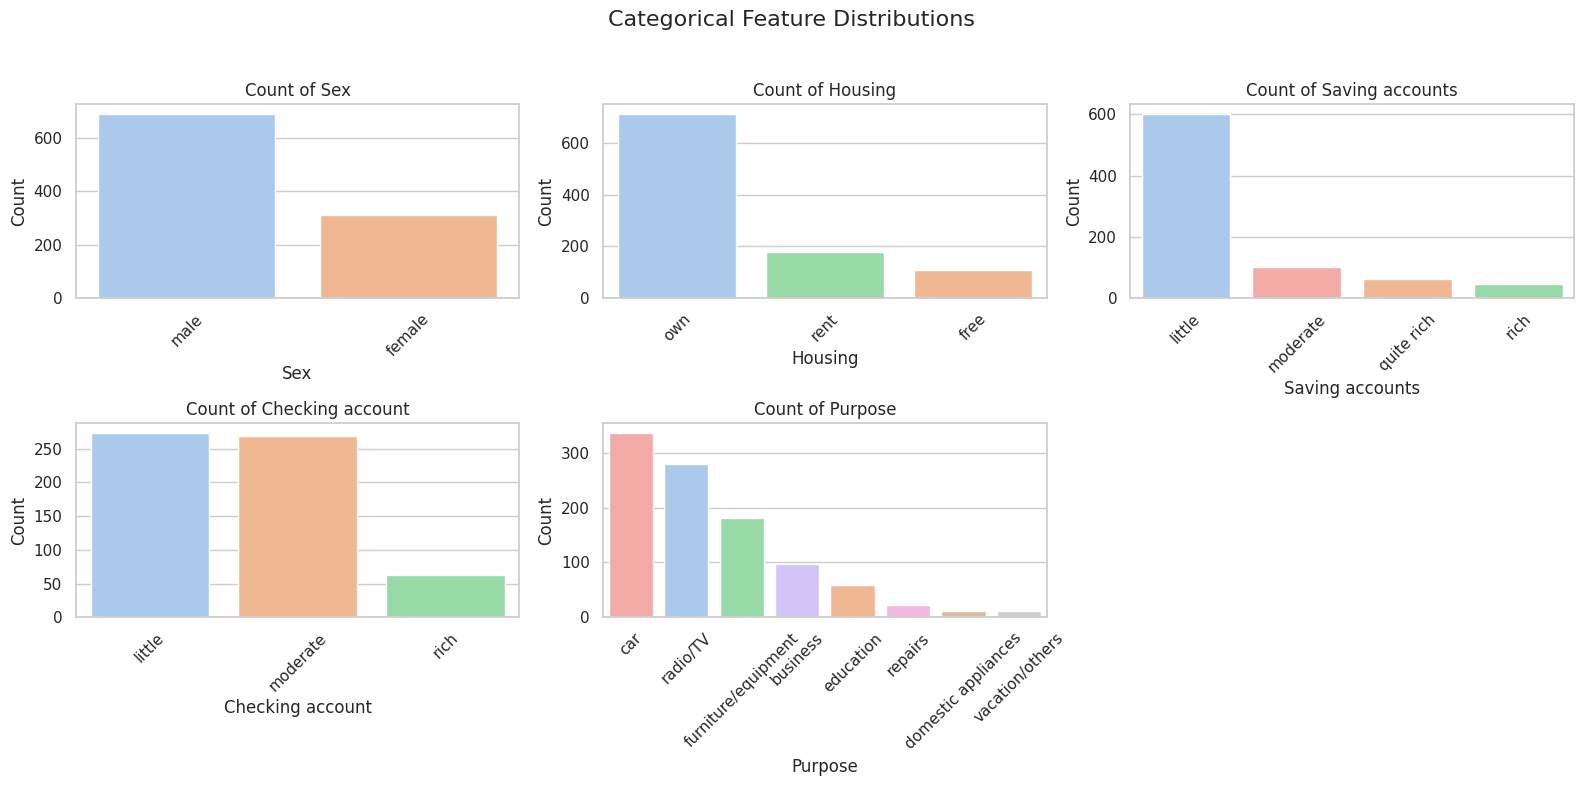

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load and clean dataset
df = pd.read_csv("/content/german_credit_data.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  # Drop unnamed index column

# Separate numeric and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Set global style
sns.set(style="whitegrid")

# NUMERIC FEATURES
num_plots = len(num_cols)
plt.figure(figsize=(16, 4 * ((num_plots + 2) // 3)))
for i, col in enumerate(num_cols):
    plt.subplot((num_plots + 2) // 3, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.suptitle("Numeric Feature Distributions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# CATEGORICAL FEATURES
cat_plots = len(cat_cols)
plt.figure(figsize=(16, 4 * ((cat_plots + 2) // 3)))
for i, col in enumerate(cat_cols):
    plt.subplot((cat_plots + 2) // 3, 3, i + 1)
    sns.countplot(data=df, x=col, hue=col, palette='pastel', legend=False, order=df[col].value_counts().index)
    plt.title(f'Count of {col}', fontsize=12)
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel("Count")
plt.suptitle("Categorical Feature Distributions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 🧼 Step 4: Data Cleaning and Label Encoding

In this step, we:
- Fill missing values in categorical columns with "unknown" to prevent errors during encoding.
- Convert categorical values to numeric using `LabelEncoder`, so that our machine learning model can understand and process these features.


In [23]:
from sklearn.preprocessing import LabelEncoder

# Fill missing categorical values
df.fillna({
    'Saving accounts': 'unknown',
    'Checking account': 'unknown'
}, inplace=True)

# Convert categorical features to numeric
label_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

## 🚨 Step 5: Create 'Risk' Column Based on Conditions

In this step, we:
- ⚖️ **Define risk conditions** based on several columns (e.g., **Credit amount**, **Duration**, **Job**, and **Age**).
- 🔄 **Apply multiple conditions** using logical operators to assign a **Risk** label (0 for low risk, 1 for high risk).

In [24]:
df['Risk'] = (
    ((df['Credit amount'] < 7500) & (df['Duration'] > 36)) |
    ((df['Job'] <= 1) & (df['Duration'] > 36)) |
    ((df['Age'] < 25) & (df['Credit amount'] > 5000)) |
    ((df['Credit amount'] > 8000) & (df['Job'] <= 1))
).astype(int)

df['Risk'].value_counts()

,count
Risk,
0,926
1,74


## 📊 Step 6: Visualizing Class Distribution of Credit Risk

In this step, we plot the distribution of the **Risk** column using `sns.countplot` to visualize how many "Good" (0) and "Bad" (1) credit risk instances exist in the dataset.

<ipython-input-25-392e9df1841e>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Risk', data=df, palette='coolwarm')


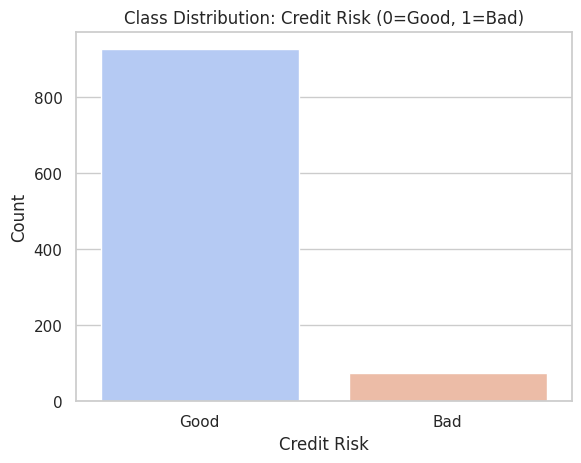

In [25]:
sns.countplot(x='Risk', data=df, palette='coolwarm')
plt.title('Class Distribution: Credit Risk (0=Good, 1=Bad)')
plt.xlabel('Credit Risk')
plt.ylabel('Count')
plt.xticks([0, 1], ['Good', 'Bad'])
plt.show()

## 🔀 Step 7: Splitting the Data and Scaling Features

In this step, we:
- Define features (X) and target (y) by separating the Risk column from the rest of the dataset.
- Scale the numeric features using **StandardScaler** to normalize the data.
- Split the data into training and testing sets using `train_test_split`, with 80% of the data used for training and 20% for testing.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['Risk'])
y = df['Risk']

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

## ⚖️ Step 8: Handling Class Imbalance with SMOTE

In this step, we:
- Balance the dataset using **SMOTE (Synthetic Minority Over-sampling Technique)**, which generates synthetic samples for the minority class in the training set.
- Apply SMOTE to the training data (X_train, y_train), creating a balanced dataset (X_train_sm, y_train_sm) where both classes (Good and Bad credit risk) have an equal number of samples, which helps improve model performance by preventing bias toward the majority class.

In [27]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

## 🤖 Step 9: Train a Random Forest Model and Evaluate

In this step, we:
- Train a Random Forest Classifier. We use the balanced training data (X_train_sm, y_train_sm).
- Make predictions on the test set (X_test) using the trained model.
- Evaluate the model by printing the accuracy score, which shows how well the model is predicting the target class.
- Generate a classification report that includes precision, recall, and F1-score for both classes ("Good Risk" and "Bad Risk") to better understand the model's performance.

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

rf = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42)
rf.fit(X_train_sm, y_train_sm)

y_pred_rf = rf.predict(X_test)

print("📊 Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=["Good Risk", "Bad Risk"]))

📊 Random Forest Accuracy: 0.97
              precision    recall  f1-score   support

   Good Risk       0.98      0.98      0.98       185
    Bad Risk       0.80      0.80      0.80        15

    accuracy                           0.97       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.97      0.97      0.97       200



## 🔄 Step 10: Train and Compare Logistic Regression and XGBoost Models

In this step, we:
- **Train a Logistic Regression model** with a maximum of 500 iterations and use it to make predictions on the test set (X_test).
- **Train an XGBoost model**, using **XGBClassifier**, with **logloss** as the evaluation metric and no label encoding, then make predictions on the test set.
- **Compare the accuracy** of both models by printing their respective accuracy scores to assess which model performs better on the test data.

In [30]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Logistic Regression
lr = LogisticRegression(max_iter=500, random_state=42)
lr.fit(X_train_sm, y_train_sm)
y_pred_lr = lr.predict(X_test)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_sm, y_train_sm)
y_pred_xgb = xgb.predict(X_test)

# Accuracy Comparison
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:51:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Logistic Regression Accuracy: 0.935
XGBoost Accuracy: 0.99


## 🔧 Step 11: Hyperparameter Tuning with GridSearchCV

In this step, we:
- Set up **GridSearchCV** to tune hyperparameters of the XGBoost model (n_estimators, max_depth, and learning_rate). GridSearchCV performs an exhaustive search over the specified parameter grid and finds the best combination of parameters.
- Run the GridSearchCV with **3-fold cross-validation** to evaluate different parameter combinations and use accuracy as the scoring metric.
- Select the best model based on the grid search results and make predictions on the test set (X_test).
- Evaluate the tuned model by printing the accuracy and a classification report that includes precision, recall, and F1-score for both "Good Risk" and "Bad Risk".

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
}

grid = GridSearchCV(XGBClassifier(eval_metric='logloss', use_label_encoder=False),
                    param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_sm, y_train_sm)

best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Best Tuned XGBoost Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, target_names=["Good Risk", "Bad Risk"]))

Best Tuned XGBoost Accuracy: 0.99
              precision    recall  f1-score   support

   Good Risk       0.99      0.99      0.99       185
    Bad Risk       0.93      0.93      0.93        15

    accuracy                           0.99       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.99      0.99      0.99       200



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:52:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## 📊 Step 12: Visualizing Feature Importance

In this step, we:
- Create a DataFrame to store the features and their corresponding importance scores from the best-tuned XGBoost model (`best_model.feature_importances_`).
- Sort the features by importance in descending order.
- Plot a bar chart using `seaborn` to visually represent the importance of each feature, with the feature names on the y-axis and their importance scores on the x-axis.

<ipython-input-32-2a5b1cedb86d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')


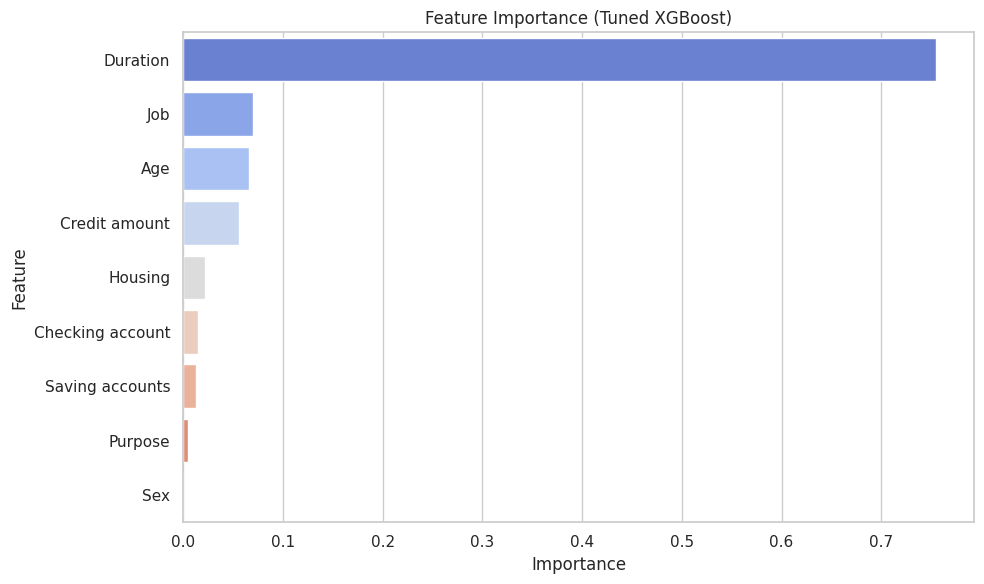

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

importance_df = pd.DataFrame({
    'Feature': df.drop(columns=['Risk']).columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')
plt.title("Feature Importance (Tuned XGBoost)")
plt.tight_layout()
plt.show()

## 🔄 Step 13: Train and Evaluate XGBoost with Data Preprocessing

In this step, we:
- Define features (X) and target (y), where the **Risk** column is separated as the target, and the rest of the columns are used as features.
- Scale the features using **StandardScaler** to standardize the numerical values, which ensures that all features are on the same scale and improves model performance.
- Split the dataset into training and testing sets, using 80% of the data for training and 20% for testing.
- Apply SMOTE to balance the class distribution in the training data, generating synthetic samples for the minority class (Bad Risk) to ensure an equal number of samples for both classes.
- Train an XGBoost model on the resampled training data and evaluate its performance on the test set.
- Evaluate the model by printing the accuracy score to see how well the model is performing.


In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Feature & target
X = df.drop(columns=['Risk'])
y = df['Risk']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE for balancing
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Train XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_res, y_train_res)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.99


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:53:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## 💾 Step 14: Save the Model and Scaler for Future Use

In this step, we:
- Save the trained XGBoost model using `pickle`, which serializes the model object and saves it to a file (`xgb_model.pkl`). This allows you to load and use the model later without retraining.
- Save the scaler (used for feature scaling) in the same way, storing it as `scalar.pkl`. This ensures that the same scaling transformations can be applied to future data when making predictions with the saved model.
  
By saving both the model and the scaler, you can easily use them later without needing to train everything again. This makes it quicker and simpler to deploy the model or use it in real-world applications whenever you need it.


In [34]:
import pickle

# Save the XGBoost model
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save the scaler
with open("scalar.pkl", "wb") as f:
    pickle.dump(scaler, f)